# Video Face Recognition (With FastAI V2)

In [1]:
from fastai2.vision.all import *

## Preparing the data

In [2]:
path = Path('./data/combined')
path

Path('data/combined')

In [95]:
face_path = Path('./data/faces')

In [96]:
files = get_image_files(face_path)
len(files)

1664

In [97]:
def label_func(file):
    return file.parent.name

label_func(files[0])

'dahyun'

In [102]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                     get_items=get_image_files,
                     get_y=parent_label,
                     splitter=GrandparentSplitter(),
                     item_tfms=Resize(224),
                     batch_tfms=Normalize.from_stats(*imagenet_stats))

dsets = dblock.datasets(face_path)
dsets.train[0]

(PILImage mode=RGB size=242x372, TensorCategory(0, dtype=torch.int32))

Number of training images: 1368
Number of valid images: 296


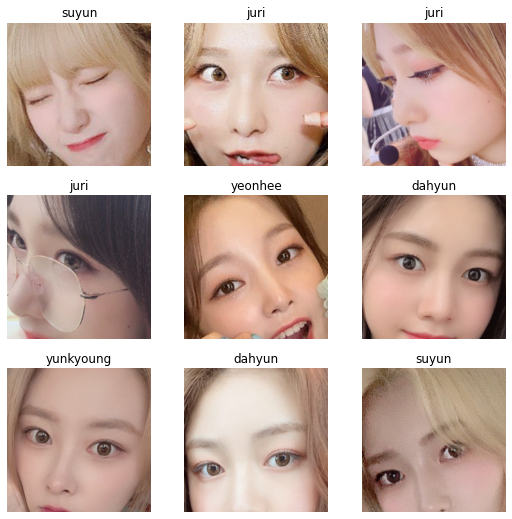

In [103]:
dls = dblock.dataloaders(face_path, num_workers=0)
dls.show_batch()
print('Number of training images:', len(dls.train_ds.items))
print('Number of valid images:', len(dls.valid_ds.items))

In [104]:
parent_label(files[0])

'dahyun'

In [105]:
tcat = Categorize(vocab=['dahyun', 'juri', 'sohee', 'suyun', 'yeonhee', 'yunkyoung'])
lbl = tcat(parent_label(files[0]))
tcat.decode(lbl)

'dahyun'

## Train the model

In [35]:
learner = cnn_learner(dls, resnet34, metrics=[accuracy, error_rate])
learner.fine_tune(1)

In [ ]:
learner.fit_one_cycle()

In [11]:
learner.fine_tune(2, 2e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.490071,1.025204,0.703928,0.296073,00:59


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.349619,0.943291,0.725076,0.274924,01:00
1,0.247415,0.806330,0.761329,0.238671,01:00


SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=6.309573450380412e-07)

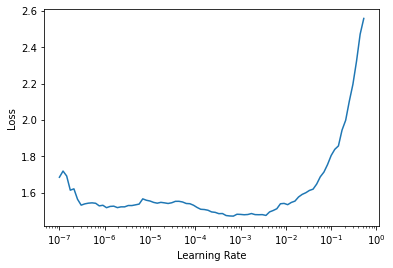

In [38]:
learner.lr_find()

In [41]:
learner = cnn_learner(dls, resnet34, metrics=accuracy, pretrained=False)

SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=6.309573450380412e-07)

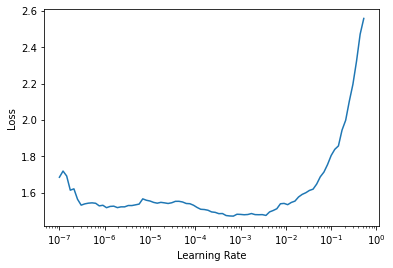

In [38]:
learner.lr_find()

In [42]:
learner.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.843837,2.051463,0.172205,01:00
1,2.657938,2.535485,0.193353,01:00
2,2.471823,3.336321,0.214502,01:00
3,2.329623,2.261407,0.232628,01:00
4,2.152672,1.831522,0.302115,01:00
5,1.995276,1.751892,0.344411,01:00
6,1.845319,1.541358,0.444109,01:00
7,1.618688,1.703093,0.410876,01:00
8,1.442325,1.655402,0.419940,01:00
9,1.297395,1.787816,0.416918,01:00


In [109]:
learner = Learner(dls, xresnet34(n_out=6), metrics=accuracy)

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.0006918309954926372)

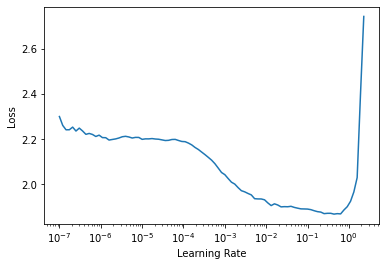

In [107]:
learner.lr_find()

In [110]:
learner.fit_one_cycle(15, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.595224,3.927401,0.155405,00:10
1,1.550617,11.464987,0.067568,00:10
2,1.523651,6.074905,0.212838,00:10
3,1.448311,6.703585,0.277027,00:10
4,1.367452,1.476944,0.378378,00:10
5,1.238741,2.208132,0.334459,00:10
6,1.105845,1.434044,0.452703,00:10
7,0.973507,1.624225,0.564189,00:10
8,0.846515,1.686077,0.520270,00:10
9,0.728790,1.415367,0.594595,00:11


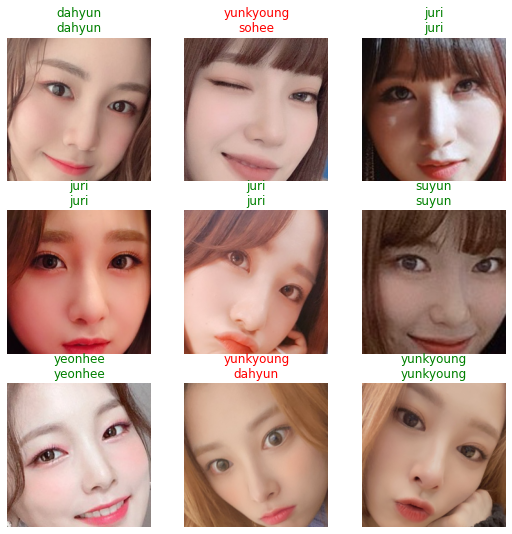

In [111]:
learner.show_results()

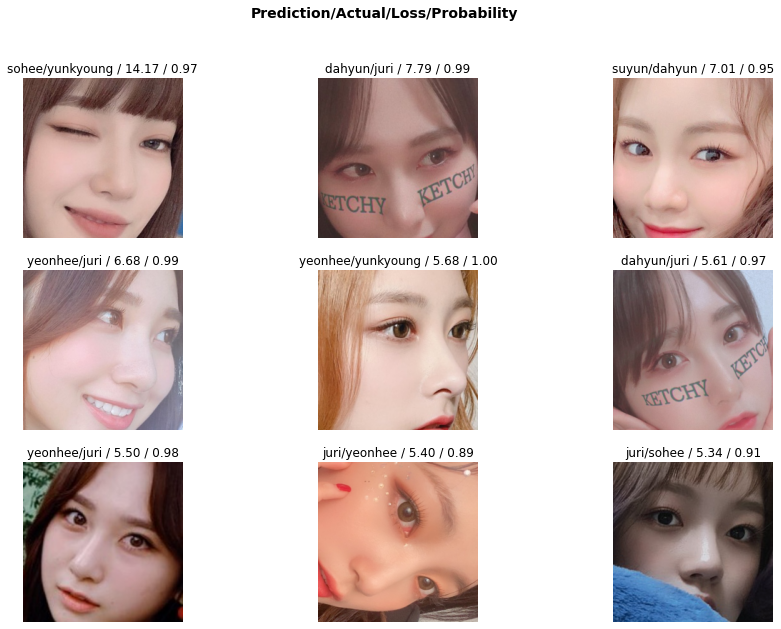

In [112]:
interp = Interpretation.from_learner(learner)
interp.plot_top_losses(9, figsize=(15,10))

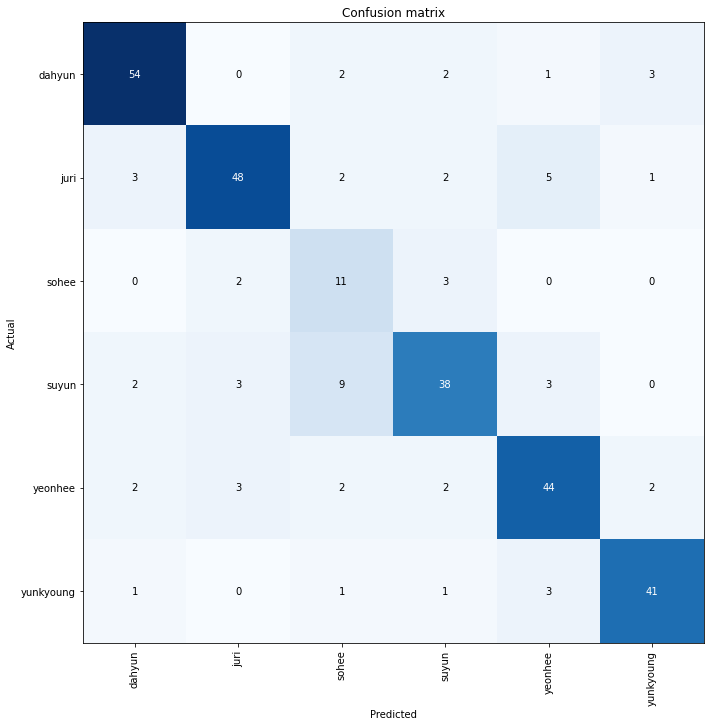

In [113]:
class_interp = ClassificationInterpretation.from_learner(learner)
class_interp.plot_confusion_matrix(figsize=(10,10))

dahyun


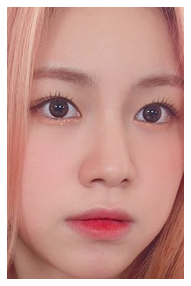

In [114]:
test_img = PILImage.create(files[0])
test_img.show()
pred, decoded_pred, full_pred = learner.predict(files[0])
print(pred)

In [15]:
learner.save('rcpc_face')

In [115]:
learner.export('model.pkl')

## Extract and predict faces

In [7]:
import cv2
import torch
import PIL

In [2]:
learn = learner.load('rcpc_face')

NameError: name 'learner' is not defined

In [8]:
learn = load_learner('model.pkl')

In [9]:
test_path = './data/twitter'
test_images = get_image_files(test_path)
len(test_images)

573

In [10]:
def read_image(fname, size=224):
    img = cv2.imread(str(fname))
    img = cv2.resize(img, (size, size))
    
    return img

In [11]:
THRESHOLD = 0.5
RESIZE = 224

idx = 472
test_image = read_image(test_images[idx])
print(test_image.shape)

(224, 224, 3)


In [12]:
img_copy = test_image.copy()
proto_txt = './data/deploy.prototxt.txt'
caffe_model = './data/weights.caffemodel'

h, w = test_image.shape[:2]
blob = cv2.dnn.blobFromImage(img_copy, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
face_model = cv2.dnn.readNetFromCaffe(proto_txt, caffe_model)
face_model.setInput(blob)
face_detector = face_model.forward()

if len(face_detector) > 0:
    for i in range(0, face_detector.shape[2]):
        rect = face_detector[0,0,i,3:7] * np.array([w,h,w,h])
        (startX, startY, endX, endY) = rect.astype('int')
        
        confidence = face_detector[0,0,i,2]
        if confidence >= THRESHOLD:
            cv2.rectangle(img_copy, (startX, startY), (endX, endY), (255,255,255), 2)
            
            face = img_copy[startY:endY, startX:endX]
            if face.size == 0:
                continue
                
            face = cv2.resize(face, (RESIZE, RESIZE))
#             print(face.shape)
            preds = learn.predict(face)
            print(preds)
            label = preds[0]
            print(label)
            text = '{}: {:.2f}%'.format(label, preds[-1].max()*100)
            cv2.putText(img_copy, text, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
    
    cv2.imshow('Prediction', img_copy)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

(224, 224, 3)


('sohee', tensor(2), tensor([4.7593e-03, 4.0540e-02, 8.9330e-01, 6.1111e-02, 2.0625e-04, 8.6161e-05]))
sohee
(224, 224, 3)


('yeonhee', tensor(4), tensor([1.7692e-03, 8.5984e-05, 1.4713e-01, 9.2240e-04, 8.4996e-01, 1.2764e-04]))
yeonhee


In [21]:
from datetime import datetime

def predict_from_video(path, learner):
    
    # load the video
    vid = cv2.VideoCapture(path)
    video_four_cc = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_fps = int(vid.get(cv2.CAP_PROP_FPS))
    video_size = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    writer = cv2.VideoWriter('result.mp4', video_four_cc, video_fps, video_size)
    face_model = cv2.dnn.readNetFromCaffe(proto_txt, caffe_model)
    
    frame_number = 0
    start_time = datetime.now()
    total_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    deciles = [int(x) for x in np.linspace(0,1,11)*total_frames]
    
    grabbed = True
    while grabbed:
        frame_number = frame_number + 1
        grabbed, frame = vid.read()
        
        if grabbed:
            (h,w) = frame.shape[:2]

            blob = cv2.dnn.blobFromImage(frame, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0), swapRB=False, crop=False)
            face_model.setInput(blob)
            detector = face_model.forward()

            if len(detector) > 0:
                for i in range(0, detector.shape[2]):
                    rect = detector[0, 0, i, 3:7] * np.array([w, h, w, h])
                    (startX, startY, endX, endY) = rect.astype("int")

                    confidence = detector[0, 0, i, 2]
                    if (confidence >= THRESHOLD):
                        cv2.rectangle(frame, (startX, startY), (endX, endY), (255, 255, 255), 2)

                        face = frame[startY:endY, startX:endX]
                        if face.size == 0:
                            continue

                        resized_face = cv2.resize(face, (RESIZE, RESIZE))

                        output = learner.predict(resized_face)
                        label = output[0]

                        cv2.putText(frame, label, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

            if frame_number in deciles:
                print('Processed frames: {} out of {} ({}%)'.format(frame_number, total_frames, np.round(frame_number*100/total_frames, 0)))

    #         cv2.imshow(frame_name, frame)
            writer.write(frame)
    #         bar.update(frame_number)
        else:
            grabbed = False

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    vid.release()
    writer.release()
    cv2.destroyAllWindows()
    
    print("[INFO] Elapsed time:", datetime.now() - start_time)

In [22]:
predict_from_video('data/videos/rcpc_loveisover_mcountdown.webm', learn)

Processed frames: 641 out of 6412 (10.0%)


Processed frames: 1282 out of 6412 (20.0%)


Processed frames: 1923 out of 6412 (30.0%)


Processed frames: 2564 out of 6412 (40.0%)


Processed frames: 3206 out of 6412 (50.0%)


Processed frames: 3847 out of 6412 (60.0%)


Processed frames: 4488 out of 6412 (70.0%)


Processed frames: 5129 out of 6412 (80.0%)


[INFO] Elapsed time: 0:06:09.518581
